# Trace Analyser

This script analyzes muon detection data from oscilloscope waveforms, performing the following tasks:
1. Reads waveform data from .trc files for PMT, SiPMs, and Trigger sensors.
2. Organizes data into time, voltage, and metadata arrays.
3. Identifies peaks in the waveform data above a specified threshold.
4. Segments the data into individual sequences.
5. Fits an exponential distribution to inter-arrival times of detected events.
6. Visualizes histograms, fitted distributions, and waveform data, including peak detection and segment markers.
7. Calculates and plots the number of detected peaks, average time between triggers, data acquisition time, and muon detection rate for each dataset.

Reading files....
data/pos-9/F1--01_muons--00000.trc
data/pos-9/F1--01_muons--00000.trc
data/pos-9/C1--01_muons--00000.trc
data/pos-9/C2--01_muons--00000.trc
data/pos-9/C4--01_muons--00000.trc
data/pos-9/C3--01_muons--00000.trc
segments:  26
Rate: 2.376422234857264 per minute


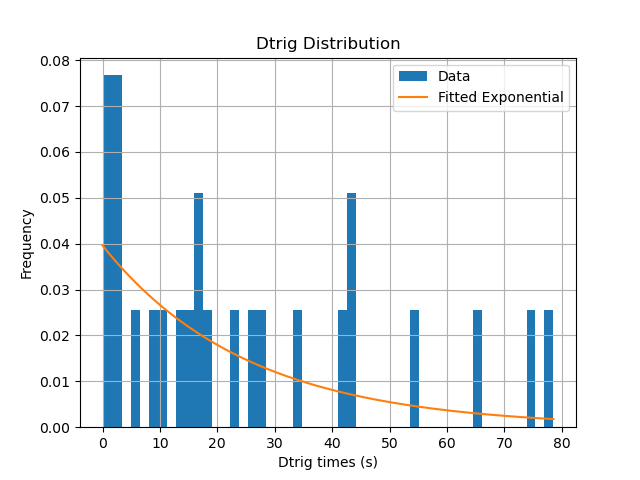

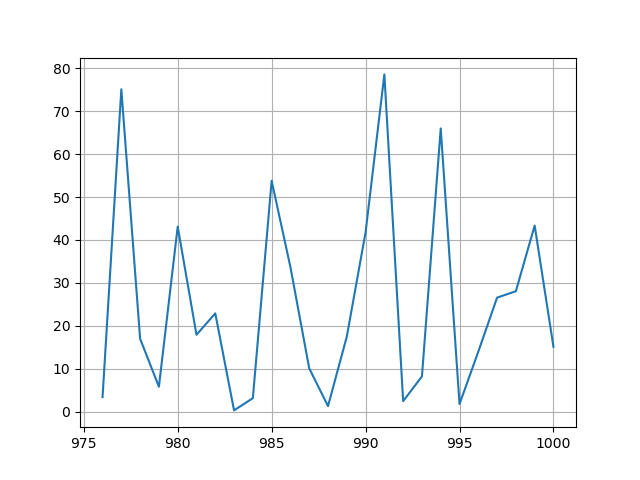

In [17]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import read_lecroy_trc as trc_reader
from scipy.signal import find_peaks, peak_widths
from scipy.stats import expon


pmt_x , pmt_y, pmt_d = [],[],[]
trig_x , trig_y, trig_d = [],[],[]
sipm1_x, sipm1_y, sipm1_d = [],[],[]
sipm2_x, sipm2_y, sipm2_d = [],[],[]
peaks = []
segments = []
dtrig_pmt, dtrig_trigger = [],[]
threshold = 30e-3


directory = "data/"
paths = ['pos-9/']#, 'pos-10/', 'pos-2/', 'pos-9/', 'pos-3/', 'pos-8/']
num = 0

for n in range(0,len(paths)): 

    print('Reading files....')

    filename = f'F1--01_muons--0000{num}.trc'
    print(directory+paths[n]+filename)
    i, dtrig_pmt_, d_ = trc_reader.readTrc(directory+paths[n]+filename)
    dtrig_pmt.append(dtrig_pmt_)

    filename = f'F1--01_muons--0000{num}.trc'
    print(directory+paths[n]+filename)
    i, dtrig_trigger_, d_ = trc_reader.readTrc(directory+paths[n]+filename)
    dtrig_trigger.append(dtrig_trigger_)


    filename = f'C1--01_muons--0000{num}.trc'
    print(directory+paths[n]+filename)
    sipm1_x_, sipm1_y_, sipm1_d_ = trc_reader.readTrc(directory+paths[n]+filename)
    sipm1_x.append(sipm1_x_) #time
    sipm1_y.append(sipm1_y_) #voltage
    sipm1_d.append(sipm1_d_) #dict


    filename = f'C2--01_muons--0000{num}.trc'
    print(directory+paths[n]+filename)
    sipm2_x_, sipm2_y_, sipm2_d_ = trc_reader.readTrc(directory+paths[n]+filename)
    sipm2_x.append(sipm2_x_) #time
    sipm2_y.append(sipm2_y_) #voltage
    sipm2_d.append(sipm2_d_) #dict

    filename = f'C4--01_muons--0000{num}.trc'
    print(directory+paths[n]+filename)
    trig_x_, trig_y_, trig_d_ = trc_reader.readTrc(directory+paths[n]+filename)
    trig_x.append(trig_x_) #time
    trig_y.append(trig_y_) #voltage
    trig_d.append(trig_d_) #dict

    filename = f'C3--01_muons--0000{num}.trc'
    print(directory+paths[n]+filename)
    pmt_x_, pmt_y_, pmt_d_ = trc_reader.readTrc(directory+paths[n]+filename)
    pmt_y_ = -pmt_y_
    pmt_x.append(pmt_x_) #time
    pmt_y.append(pmt_y_) #voltage
    pmt_d.append(pmt_d_) #dict

    
    seq = pmt_d_['SUBARRAY_COUNT']  # Number of sequences taken (~100)
    tot = pmt_d_['LAST_VALID_PNT']  # Total number of points across all data sets
    step = np.round(tot / seq).astype(int)  # Number of points per sequence

    segments_ = np.arange(0,tot,step)
    print("segments: ",len(segments_))

    # Reshape amplitude array to reflect the sequences and find the mean
    ym = np.reshape(pmt_y_, [seq, step]).mean(axis=0)

    peaks_ = []
    # Find the peak position of the mean sequence
    for seg in segments_:
        peak = np.argmax(ym) #position of peak
        peak += seg #where peak should be for each segment
        true_peak = (peak-500) + np.argmax(pmt_y_[peak-500:peak+500])
        if pmt_y_[true_peak] > threshold: #above noise
            peaks_.append(true_peak)


            

    peaks.append(np.asarray(peaks_))
    segments.append(np.asarray(segments_))


    params = expon.fit(dtrig_pmt, floc=0) #fitting an exponential to dtrig values
    loc, scale = params
    print("Rate:", (1/scale)*60, "per minute")

    plt.figure()
    plt.hist(dtrig_pmt_, bins=50, density = True, label = "Data")
    # plt.hist(dtrig_trigger_, bins=50, density = True, label = "Data")
    x_fit = np.linspace(0, max(dtrig_pmt_), 10000)
    pdf_fitted = expon.pdf(x_fit, loc, scale) #using the fitting params create an exp to plot
    plt.plot(x_fit[1:], pdf_fitted[1:], label='Fitted Exponential')
    plt.title("Dtrig Distribution")
    plt.xlabel("Dtrig times (s)")
    plt.ylabel("Frequency")
    plt.legend(loc = "upper right")
    plt.grid()
    plt.show()


    plt.figure()
    plt.plot(i,dtrig_pmt_)
    plt.grid()
    plt.show()




1
pos-9
Num of peaks: 26
dtrig: 25.24803846720606 s
Data acqusition time for pmt events: 10.520016028002525 mins
Rate: 2.471479124251555 events per minute


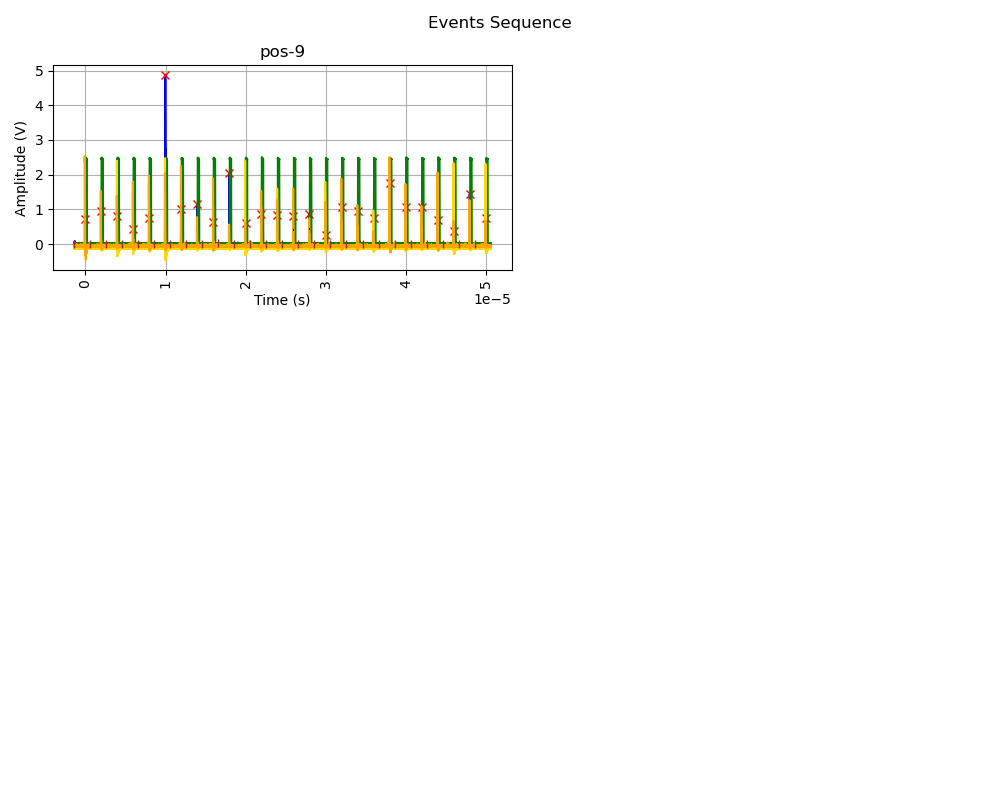

In [18]:
#all peaks and files

av_rate = []

fig = plt.figure(figsize=(10, 8))

for n in range(1,len(paths)+1): # cycle thorugh all files
    print(n)
    time_pmt = np.mean(dtrig_pmt[n-1])
    total_time_pmt = np.sum(dtrig_pmt[n-1])
    time_trigger = np.mean(dtrig_trigger[n-1])
    total_time_trigger = np.sum(dtrig_trigger[n-1])
    i =  np.argmin(np.abs(pmt_x[n-1] - total_time_pmt))
    pmt_x_ = pmt_x[n-1]
    pmt_y_ = pmt_y[n-1]
    pmt_p_ = peaks[n-1]
    trig_x_ = trig_x[n-1]
    trig_y_ = trig_y[n-1]
    sipm1_x_ = sipm1_x[n-1]
    sipm1_y_ = sipm1_y[n-1]
    sipm2_x_ = sipm2_x[n-1]
    sipm2_y_ = sipm2_y[n-1]
    s_ = segments[n-1]
    av_rate.append(len(pmt_p_)/(total_time_pmt/60)) #number of peaks over total data quisition time - muon rate
  
    print(paths[n-1][0:-1])
    print("Num of peaks:", len(pmt_p_))
    print("dtrig:", time_pmt, "s")
    print("Data acqusition time for pmt events:", total_time_pmt/60, "mins")
    print("Rate:", len(pmt_p_)/(total_time_pmt/60), "events per minute")

    ax = fig.add_subplot(3, 2, n)  # 3 rows, 2 columns, subplot index i
    ax.set_title(str(paths[n-1][0:-1]))
    ax.plot(pmt_x_,pmt_y_, color = 'blue') #plot PMT signal
    ax.plot(pmt_x_[pmt_p_], pmt_y_[pmt_p_], "x", color = 'red') #plot events peaks
    ax.plot(trig_x_,trig_y_, color = 'green') #plot triggers
    ax.plot(sipm1_x_,sipm1_y_, color = 'gold') #plot triggers
    ax.plot(sipm2_x_,sipm2_y_, color = 'orange') #plot triggers
    ax.plot(pmt_x_[s_], pmt_y_[s_], "|", color = 'brown') #plot segments
    widths, height, left_ips, right_ips = peak_widths(pmt_y_, pmt_p_, rel_height=0.5)
    for i in range(len(pmt_p_)): #plot FWHM - peak widths
        ax.hlines(y=height[i], xmin=pmt_x_[int(left_ips[i])], xmax=pmt_x_[int(right_ips[i])], color='black')

    ax.grid()
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Amplitude (V)")

fig.suptitle("Events Sequence")
plt.xticks(rotation = 90)
plt.tight_layout()
plt.show()



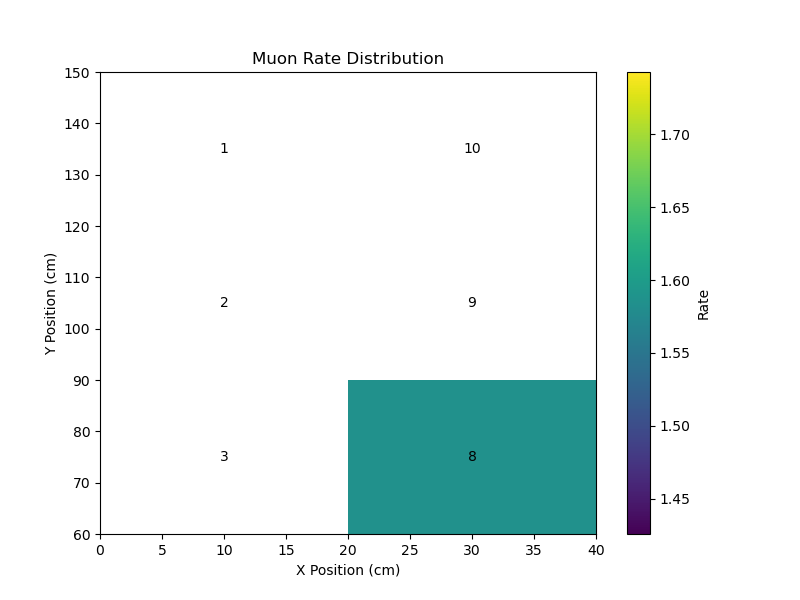

In [3]:

# Define your specific grid labels
labels = [[3, 8],[2, 9],[1, 10]]

X = np.arange(0,60,20)  
Y = np.arange(60,180,30)    

# Define rates for each position in the grid
rates = np.array([
    [np.nan, av_rate[0]],
    [np.nan,np.nan],
    [np.nan, np.nan]
    # [av_rate[4], av_rate[5]],
    # [av_rate[2], av_rate[3]],
    # [av_rate[0], av_rate[1]]
])
# Create meshgrid for positions
X_grid, Y_grid = np.meshgrid(X, Y)

# Plotting the heatmap
plt.figure(figsize=(8, 6))
c = plt.pcolormesh(X_grid, Y_grid, rates, cmap='viridis', shading='auto', vmin=np.nanmin(rates), vmax=np.nanmax(rates))
plt.colorbar(c, label='Rate')

# Add text annotations for each cell
for i in range(len(labels)):
    for j in range(len(labels[0])):
        plt.text(X[j]+10, Y[i]+15, f'{labels[i][j]}', color='black', ha='center', va='center', fontsize=10)

# Set labels and title
plt.xlabel('X Position (cm)')
plt.ylabel('Y Position (cm)')
plt.title('Muon Rate Distribution')

plt.show()



NameError: name 'y' is not defined

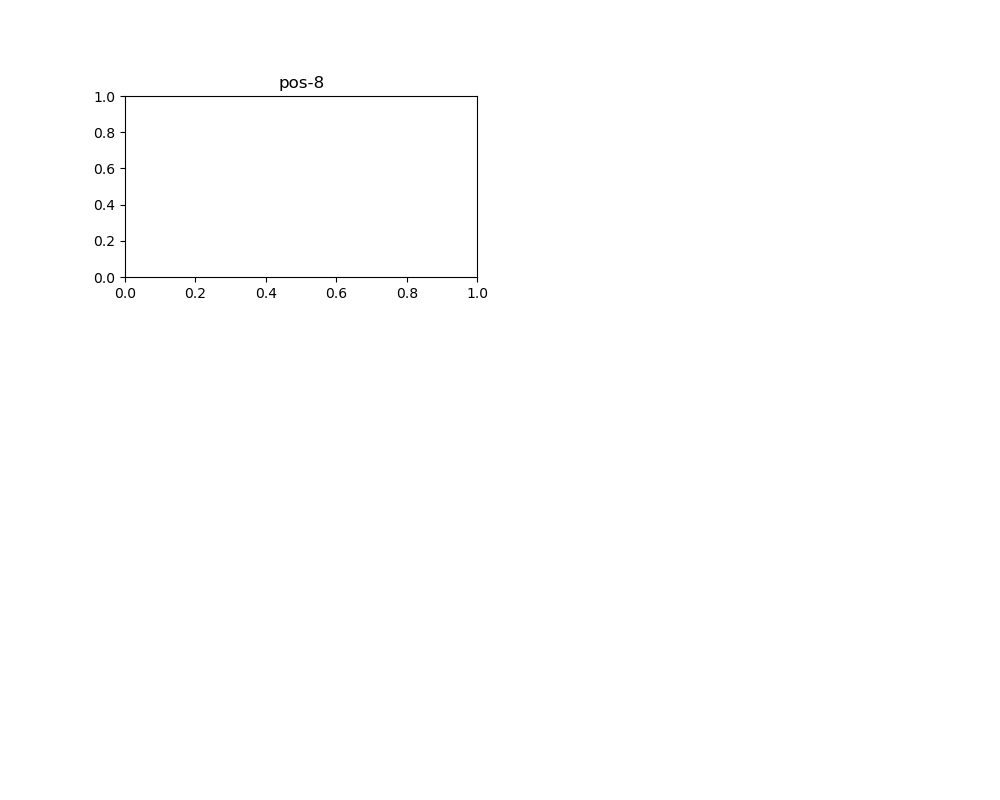

In [4]:

fig = plt.figure(figsize=(10, 8))

# Add subplots
for n in range(1,len(paths)+1): 
    ax = fig.add_subplot(3, 2, n)  # 3 rows, 2 columns, subplot index i
    ax.set_title(str(paths[n-1][0:-1]))
    ax.hist(y[n-1][np.where(y[n-1] > 0.1)[0]],bins = 100)  # Example plot
    ax.grid()
    ax.set_ylabel("Frequency")
    ax.set_xlabel("Amplitude (V)")

fig.suptitle("Amplitude Distribtuion")
plt.tight_layout()
plt.show()


In [ ]:

fig = plt.figure(figsize=(10, 8))

# Add subplots
for n in range(1,len(paths)+1): 

    time = pmt_x[n-1]
    signal = pmt_y[n-1]
    peaks_ = peaks[n-1]

    pulse_spans = []

    # Calculate peak widths at half maximum
    results_half = peak_widths(signal, peaks_, rel_height=0.9)
    fwhm = results_half[0]




    start_indices = results_half[2].astype(int)
    end_indices = results_half[3].astype(int)
    fwhm_times = time[start_indices], time[end_indices]

  
    for i, peak in enumerate(peaks_):
        if signal[peak] > 0.1:
            start_time = time[start_indices[i]]
            end_time = time[end_indices[i]]
            pulse_span = end_time - start_time
            pulse_spans.append(pulse_span)
            
        #print(f"Peak at index {peak} (time={time[peak]}): FWHM = {fwhm[i]} data points, Time span of pulse = {pulse_span} units of time")


    fig.suptitle("FWHM Distribution")
    ax = fig.add_subplot(3, 2, n)  # 3 rows, 2 columns, subplot index i
    ax.set_title(str(paths[n-1][0:-1]))
    ax.hist(pulse_spans,bins = 20)  # Example plot
    ax.grid()
    ax.set_ylabel("Frequency")
    ax.set_xlabel("FWHM (s)")



plt.tight_layout()
plt.show()


In [ ]:
fig = plt.figure(figsize=(10, 8))

for n in range(1,len(paths)+1): 
    s = pmt_d[n-1]['SUBARRAY_COUNT']
    tot = pmt_d[n-1]['LAST_VALID_PNT']/s
    ym = np.reshape(pmt_y[n-1], [s,int(np.round(tot,1))]).mean(axis=0)
    peak = find_peaks(ym, height = 0.1, prominence=0.1)
    ax = fig.add_subplot(3, 2, n)  # 3 rows, 2 columns, subplot index i
    ax.set_title(str(paths[n-1][0:-1]))
    ax.plot(ym) 
    ax.plot(peak[0],ym[peak[0]], "x")
    ax.grid()
    ax.set_ylabel("Amplitude (V)")
    ax.set_xlabel("Indice within sequence")

fig.suptitle("Mean Pulse Shape")
plt.tight_layout()
plt.show()